# Testing with different probabilities in the loop
for this let's take 100 terms and run it via mixed strategy of LO & RI

In [1]:
import random
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions
from deap import tools, base, creator
import seaborn as sns

sys.path.append("../")
from calculus.term import *
from calculus.strategy import *
from calculus.generation import *
from calculus.generation_threading import *

from calculus_utils.drawing import *
from calculus_utils.algorithms import *
from calculus_utils.outliers_cleaning import clear_arr

from vd_env.lambda_env import LambdaEnv
from vd_env.run_greedy_policy import run_greedy_policy
from vd_env.run_e_greedy_policy import run_e_greedy_policy

In [2]:
RANDOM_AVERAGE_COUNT = 20

terms, stepsLO = gen_filtered_lambda_terms_v2(count_terms=120)
stepsRI = [term.normalize(RightmostInnermostStrategy())[1] for term in tqdm(terms)]
stepsRand = [
    sum(term.normalize(RandomStrategy())[1] for i in range(RANDOM_AVERAGE_COUNT))
    / RANDOM_AVERAGE_COUNT
    for term in tqdm(terms)
]

100%|██████████| 122/122 [00:40<00:00,  2.99it/s]


In [3]:
inf_inxs_RI = []
inf_inxs_rand = []
for i in range(len(stepsRI)):
    if stepsRI[i] == np.inf:
        inf_inxs_RI.append(i)
    if stepsRand[i] == np.inf:
        inf_inxs_rand.append(i)

print(inf_inxs_RI)
print(inf_inxs_rand)

[61, 82, 83, 94, 109, 118]
[61, 64, 82, 83, 95, 109, 118]


In [9]:
terms_saved = terms[::]

In [10]:
for inx in inf_inxs_RI[::-1]:
    del terms[inx]

In [16]:
stepsRand = [
    sum(term.normalize(RandomStrategy())[1] for i in range(RANDOM_AVERAGE_COUNT))
    / RANDOM_AVERAGE_COUNT
    for term in tqdm(terms)
]

100%|██████████| 116/116 [00:22<00:00,  5.15it/s]


In [13]:
stepsLO = [term.normalize(LeftmostOutermostStrategy())[1] for term in tqdm(terms)]

100%|██████████| 116/116 [00:04<00:00, 28.98it/s]


In [14]:
stepsRI = [term.normalize(RightmostInnermostStrategy())[1] for term in tqdm(terms)]

100%|██████████| 116/116 [00:01<00:00, 67.35it/s]


In [17]:
inf_inxs_RI = []
inf_inxs_rand = []
for i in range(len(stepsRI)):
    if stepsRI[i] == np.inf:
        inf_inxs_RI.append(i)
    if stepsRand[i] == np.inf:
        inf_inxs_rand.append(i)

print(inf_inxs_RI)
print(inf_inxs_rand)

[]
[63, 91, 106]


In [18]:
for inx in inf_inxs_rand[::-1]:
    del terms[inx]

In [19]:
print(len(terms))

113


In [20]:
stepsRand = [
    sum(term.normalize(RandomStrategy())[1] for i in range(RANDOM_AVERAGE_COUNT))
    / RANDOM_AVERAGE_COUNT
    for term in tqdm(terms)
]

100%|██████████| 113/113 [00:03<00:00, 35.31it/s]


In [21]:
stepsLO = [term.normalize(LeftmostOutermostStrategy())[1] for term in tqdm(terms)]

100%|██████████| 113/113 [00:00<00:00, 941.45it/s]


In [22]:
stepsRI = [term.normalize(RightmostInnermostStrategy())[1] for term in tqdm(terms)]

100%|██████████| 113/113 [00:00<00:00, 697.38it/s]


In [23]:
inf_inxs_RI = []
inf_inxs_rand = []
for i in range(len(stepsRI)):
    if stepsRI[i] == np.inf:
        inf_inxs_RI.append(i)
    if stepsRand[i] == np.inf:
        inf_inxs_rand.append(i)

print(inf_inxs_RI)
print(inf_inxs_rand)

[]
[]


In [26]:
steps_mixed_all = []
expected_values = []
values = list(range(0, 101, 5))
iters = len(values) - 1

for inx, p_lo in enumerate(values):
    p = (p_lo / 100, 1 - p_lo / 100)
    steps = [
        sum(
            [
                term.normalize(
                    MixedStrategy(
                        [LeftmostOutermostStrategy(), RightmostInnermostStrategy()], p
                    )
                )[1]
                for i in range(RANDOM_AVERAGE_COUNT)
            ]
        )
        / RANDOM_AVERAGE_COUNT
        for term in tqdm(terms, desc=f"it {inx} / {iters}")
    ]
    steps_mixed_all.append(steps)

it 20 / 20: 100%|██████████| 113/113 [00:02<00:00, 47.95it/s]


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 23.87it/s]


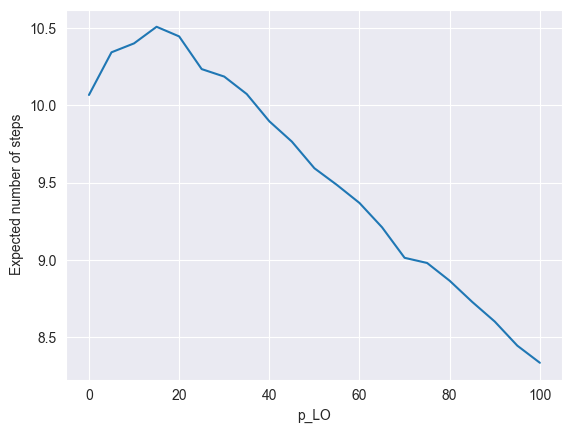

In [27]:
for steps in steps_mixed_all:
    steps = list(filter(lambda x: x != float("inf"), steps))
    steps = list(filter(lambda x: x != 0, steps))

    distributions = get_common_distributions()
    distributions.remove("expon")
    f_ln = Fitter([np.log(step) for step in steps], distributions=distributions)
    f_ln.fit()

    mu, sigma = f_ln.fitted_param["norm"]
    result = np.e ** (mu + (sigma**2) / 2)
    expected_values.append(result)

plt.plot(values, expected_values)
plt.xlabel("p_LO")
plt.ylabel("Expected number of steps")
plt.show()